In [1]:
import sys
import gpytorch
import numpy as np
import pandas as pd
import torch
from datetime import datetime
from scipy.stats import qmc
from scipy.stats import norm, multivariate_normal
import itertools
from itertools import combinations_with_replacement, combinations, permutations
import scipy.special
import copy
import Tasmanian
import matplotlib.pyplot as plt

import bo_methods_lib
from bo_methods_lib.bo_methods_lib.GPBO_Classes_New import * #Fix this later
from bo_methods_lib.bo_methods_lib.GPBO_Class_fxns import * #Fix this later
from bo_methods_lib.bo_methods_lib.GPBO_Classes_plotters import * #Fix this later
import pickle
import gzip

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import integrate

import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

/afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/Toy_Problem_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-08-06 12:23:48.941245: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-06 12:23:48.941295: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-06 12:23:48.942578: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-06 12:23:48.950489: I tensorflow/core/platform/cpu_feature_guard

In [2]:
def func1(x):
    # for 2D: f(x)= 1 - x1^2 - x2^2
    return np.array(1 - x[0]**2 - x[1]**2).reshape(1,-1).flatten()

def func2(x):
    return np.array(np.maximum(func1(x), 0)).flatten()

def func3(x):
    return np.array(0.5*(np.sqrt(func1(x)**2 + 1e-5) + func1(x))).flatten()

def func4(x):
    return np.array(np.sin(x[0])*x[1]).flatten()

def func5(x):
    return np.array(x[0]*x[1]).flatten()

#Create test functions*pdf(normal)
def get_mean_covar(vars_shape, mean = False, covar = False):
    np.random.seed = 1
    if mean is True:
        mean = np.array([1.0,1.2])#np.ones(vars.shape[1])
    else:
        mean = np.zeros(vars_shape)
    if covar is True:
        B = np.ones((vars_shape,vars_shape))*0.5
        covar = np.dot(B.T, B) + 0.5*np.eye(vars_shape)
    else:
        covar = np.eye(vars_shape)

    return mean, covar
    
def pdf_func(vars, mean, covar):
    np.random.seed = 1
    pdf = multivariate_normal.pdf(vars.T, mean=mean, cov=covar)
    return pdf

#Create test functions*pdf(normal)
# def func1_pdf(x1, x2, mean = True, covar = True):
#     # for 2D: f(x)= 1 - x1^2 - x2^2
#     vars = np.array([x1,x2]).reshape(-1,1)
#     np.random.seed = 1
#     mean, covar = get_mean_covar(len(vars), mean = mean, covar = covar)
#     pdf = multivariate_normal.pdf(vars.T, mean=mean, cov=covar)
#     return func1(vars)*pdf

In [3]:
#Test MC vs Sparse Grid on a fxn*norm.pdf w/ gaussian random variables
def plot_sg_points(points_p, func):
    # Define the range for the input space (for visualization)
    min = np.min(points_p, axis=0)
    max = np.max(points_p, axis=0)
    x_range = np.linspace(min[0], max[0], 100)
    y_range = np.linspace(min[1], max[1], 100)
    X, Y = np.meshgrid(x_range, y_range)

    # Evaluate the function over the grid
    Z = func([X,Y]).reshape(X.shape)

    # Plotting the function surface and points
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot the continuous function surface
    ax.plot_surface(X, Y, Z, alpha=0.5, cmap='viridis')

    # Scatter plot of the points from Tasmanian grid
    values = func(points_p.T)
    ax.scatter(points_p[:, 0], points_p[:, 1], values, c='r', marker='o')

    # Labeling the plot
    ax.set_title('Num Points =' + str(len(points_p)), fontsize=20)
    ax.set_xlabel(r"$ϵ_1$", fontsize=20)
    ax.set_ylabel(r"$ϵ_2$", fontsize=20)
    ax.set_zlabel(r"$f(ϵ)$", fontsize=20)

    # Show plot
    plt.show()

# def sg_integ_gauss(func, dim, gp_mean, gp_covar, depth =5, seed = 1, verbose = False):
#     np.random.seed = seed
#     #Get grid points and weights
#     grid_p = Tasmanian.SparseGrid()
#     grid_p.makeGlobalGrid(dim, 0, depth, "hyperbolic", 'gauss-hermite-odd')
#     points_p_old = grid_p.getPoints()*np.sqrt(2)
#     weights_p = grid_p.getQuadratureWeights()
            
#     #Diagonalize covariance matrix
#     L = scipy.linalg.cholesky(np.real(gp_covar), lower=True)
#     transformed_points = L@points_p_old.T
#     points_p = gp_mean[:, np.newaxis].T + transformed_points.T

#     if verbose:
#         plot_sg_points(points_p, func)

#     #Evaluate function
#     y = func(points_p.T)

#     integ = (np.pi**(-dim/2))*y@weights_p.T
#     return integ

def sg_integ_gauss(func, pdf, dim, gp_mean, gp_covar, budget=2000, grid_type= "level", seed = 1, verbose = False):
    np.random.seed = seed
    #Get grid points and weights

    # we compare isotropic grid with 3 different refinement strategies
    initial_level = 4

    def func_pdf(x, y=0):
        return func(x)*pdf(x, gp_mean, gp_covar)
    
    if grid_type == "rleja":
        grid_p = Tasmanian.makeGlobalGrid(dim, 1, initial_level, 'level', 'rleja')
        # loop while at least one grid hasn't exhausted the budget
        while grid_p.getNumLoaded() < budget: 
            Tasmanian.loadNeededValues(func_pdf, grid_p, 0)
            # set anisotropic curved update using at least 10 new points
            grid_p.setAnisotropicRefinement("qphyperbolic", 10, 0)
    elif grid_type == "gauss":
        depth = 0
        num_points = 0
        # Compute the maximum depth based on the budget
        while num_points <= budget:
            depth += 1
            # Generate the global grid with the current depth
            grid_p = Tasmanian.makeGlobalGrid(dim, 1, depth, "qphyperbolic", 'gauss-hermite-odd')
            
            # Get the number of points on the grid
            num_points = grid_p.getNumPoints()

            # Check if the number of points exceeds the budget
            if num_points > budget:
                if depth > 1:
                    depth -= 1
                break

        # while grid_p.getNumPoints() < budget: 
        #     depth += 1
        #     grid_p = Tasmanian.makeGlobalGrid(dim, 1, depth, "qphyperbolic", 'gauss-hermite-odd')
        print("depth: ", depth)
        grid_p = Tasmanian.makeGlobalGrid(dim, 1, depth, "qphyperbolic", 'gauss-hermite-odd')

    elif grid_type == "localp":
        # we compare isotropic grid with 3 different refinement strategies
        initial_level = 2
        grid_p = Tasmanian.makeLocalPolynomialGrid(dim, 1, initial_level, -1, 'localp')
        # loop while we still have a budget
        while grid_p.getNumNeeded() > 0 and grid_p.getNumPoints() < budget: 
            Tasmanian.loadNeededValues(func_pdf, grid_p, 0)
            grid_p.setSurplusRefinement(1e-5, sCriteria=Tasmanian.lsTsgRefineTypes[-1], iOutput= 0)

        # bnds = np.full((dim, 2), [-np.inf, np.inf])
        # print(bnds)
        # grid_p.setDomainTransform(bnds)

    points_p_old = grid_p.getPoints()*np.sqrt(2)
    weights_p = grid_p.getQuadratureWeights()
    #Diagonalize covariance matrix
    L = scipy.linalg.cholesky(np.real(gp_covar), lower=True)
    transformed_points = L@points_p_old.T

    points_p = gp_mean[:, np.newaxis].T + transformed_points.T
    if verbose:
        plot_sg_points(points_p, func)
    #Evaluate function
    y = func(points_p.T)

    integ = (np.pi**(-dim/2))*y@weights_p.T

    return integ

def mc_integ_gauss(func, dim, n, gp_mean, gp_covar, seed = 1):
    # Monte Carlo integration of given function over domain from a to b (for each parameter)
    # dim: dimensions of function
    #Initialize total ei  
    # n = math.ceil((norm.ppf(1-0.05/2)/0.05)**2)  
    # np.random.seed(seed)

    #Get random variable from normal distribution
    x_list = np.random.multivariate_normal(gp_mean, gp_covar, n)

    #Evaluate function
    y = func(x_list.T)

    y_mean =  np.mean(y)

    integ = y_mean

    return integ

Mean: [1.  1.2]
Covar: [[1.  0.5]
 [0.5 1. ]]
200
depth:  76


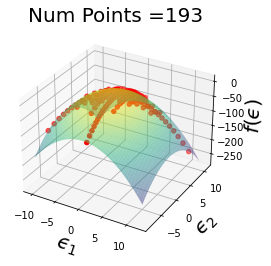

2000
depth:  360


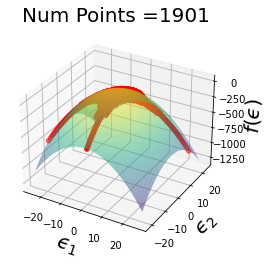

5000
depth:  692


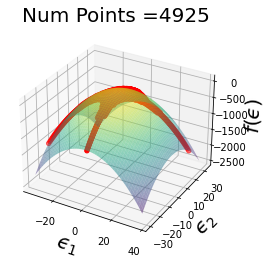

10000
depth:  1084


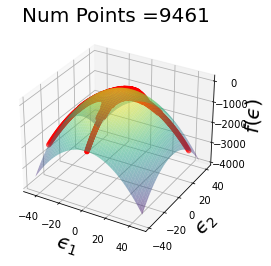

['scipy', 'mc n=200', 'mc n=2000', 'mc n=5000', 'mc n=10000', 'sg gauss200', 'sg gauss2000', 'sg gauss5000', 'sg gauss10000'] [-3.4399999999619904, -3.5028768505269907, -3.448012396419431, -3.3860201033444013, -3.36745221919577, -3.4399999999990127, -3.439999999999512, -3.439999999999677, -3.439999999999652]
200
depth:  76


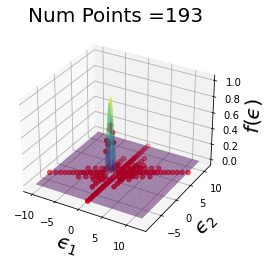

2000
depth:  360


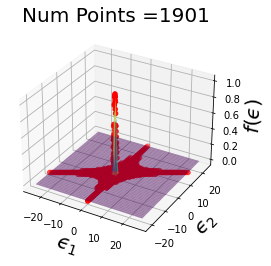

5000
depth:  692


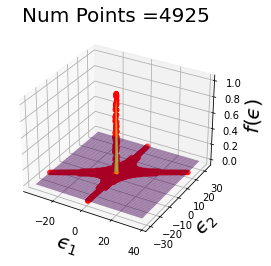

10000
depth:  1084


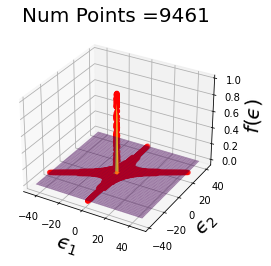

['scipy', 'mc n=200', 'mc n=2000', 'mc n=5000', 'mc n=10000', 'sg gauss200', 'sg gauss2000', 'sg gauss5000', 'sg gauss10000'] [0.11255464053742868, 0.1102924154705383, 0.11490038907497803, 0.11101185779666362, 0.11002535049868968, 0.08000589930160998, 0.10975576523270146, 0.11527349449129898, 0.11087748424127918]
200
depth:  76


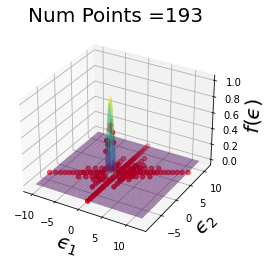

2000
depth:  360


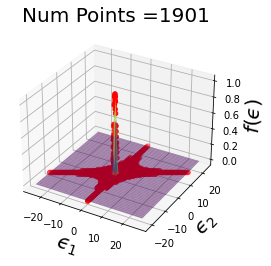

5000
depth:  692


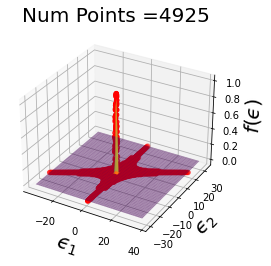

10000
depth:  1084


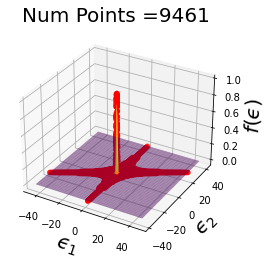

['scipy', 'mc n=200', 'mc n=2000', 'mc n=5000', 'mc n=10000', 'sg gauss200', 'sg gauss2000', 'sg gauss5000', 'sg gauss10000'] [0.11256180227130926, 0.10303228809446345, 0.10374121107054822, 0.11687789971910724, 0.11184706602131707, 0.07998799124078121, 0.10982144526503282, 0.11525667362310071, 0.11089167572854813]
200
depth:  76


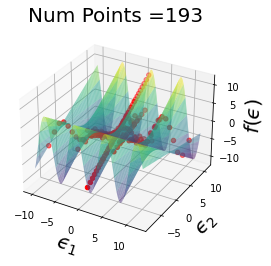

2000
depth:  360


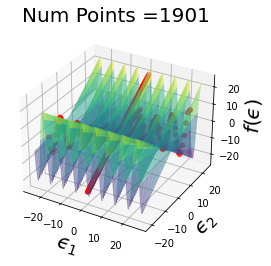

5000
depth:  692


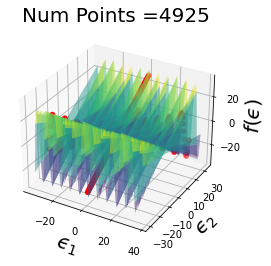

10000
depth:  1084


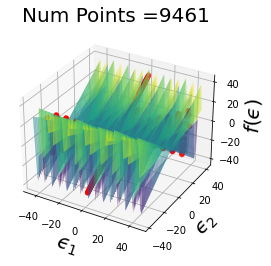

['scipy', 'mc n=200', 'mc n=2000', 'mc n=5000', 'mc n=10000', 'sg gauss200', 'sg gauss2000', 'sg gauss5000', 'sg gauss10000'] [0.7763084990366077, 0.9458759569851369, 0.7624517030299462, 0.7740688434998295, 0.7872035989759805, 0.7763084988645284, 0.7763084988646342, 0.7763084988646085, 0.7763084988645008]
200
depth:  76


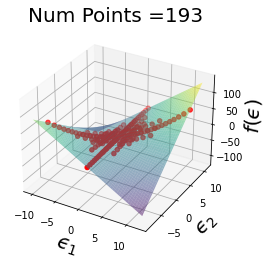

2000
depth:  360


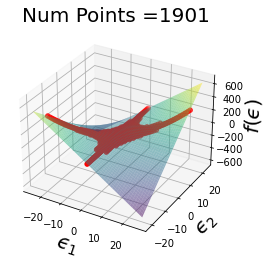

5000
depth:  692


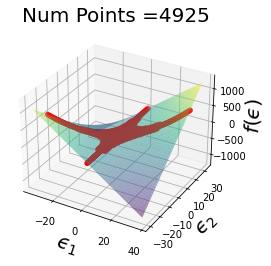

10000
depth:  1084


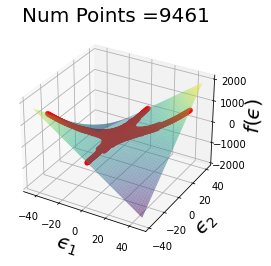

['scipy', 'mc n=200', 'mc n=2000', 'mc n=5000', 'mc n=10000', 'sg gauss200', 'sg gauss2000', 'sg gauss5000', 'sg gauss10000'] [1.6999999999848527, 1.8931985088466672, 1.7541004089010657, 1.7466672967241894, 1.7074988322036366, 1.6999999999995254, 1.6999999999998179, 1.6999999999998119, 1.6999999999997337]


In [4]:
#Test MC vs Sparse Grid on a fxn*norm.pdf w/ gaussian random variable
# func_list = [func1, func2, func3, func4, func5] #, func5, func6, func7, func8, func9]
# func_list2 = [func1_pdf,  func2_pdf, func3_pdf, func4_pdf, func5_pdf]

func_list = [func1, func2, func3, func4, func5] #, func5, func6, func7, func8, func9]

seed = 1
budgets_sg = [200, 2000, 5000, 10000]
budgets_mc = [200, 2000, 5000, 10000]
levs = ['gauss']
add_mean = True
add_var = True
show_plots = True
eval_scipy = True

for i in range(len(func_list)):
    column_names = []
    func = func_list[i]

    def func_pdf(x1, x2, func, pdf, mean, covar):
        x = np.array([x1,x2]).reshape(-1,1)
        return func(x)*pdf(x, mean, covar)
    
    dim =2
    mean, covar = get_mean_covar(dim, mean=add_mean, covar = add_var)
    if eval_scipy:
        z_scipy = [integrate.dblquad(func_pdf, -np.inf, np.inf, -np.inf, np.inf, args = (func, pdf_func, mean, covar))[0]]
        column_names += ["scipy"]
    
    if i == 0:
        print("Mean:", mean)
        print("Covar:", covar)
    #Evaluate "improvement (the normal function)" integral using MC
    z_mc = []
    for k in range(len(budgets_mc)):
        z_mc.append(mc_integ_gauss(func, dim, budgets_mc[k], mean, covar))
        column_names += ["mc n="+str(budgets_mc[k])]

    #Evaluate "improvement (the normal function)" integral using sparse grid
    z_sg = []
    for j in range(len(budgets_sg)):
        print(budgets_sg[j])
        for k in range(len(levs)):
            z_sg.append(sg_integ_gauss(func, pdf_func, dim, mean, covar, budget=budgets_sg[j], 
                                        grid_type= levs[k], seed = 1, verbose = show_plots)) 
            column_names += ["sg " + str(levs[k]) + str(budgets_sg[j])]
    
    z_sg_l = []
    # for j in range(len(levs)):
    #     print(levs[j])
    #     z_sg_l.append(sg_integ_gauss(func, pdf_func, dim, mean, covar, budget=budgets_sg[2], 
    #                                  grid_type= levs[j], seed = 1, verbose = show_plots)) 
    #     column_names += ["sg " + levs[j] + str(budgets_sg[2])]

    #Add to dataframe results
    iter_df = pd.DataFrame(columns=column_names)
    if eval_scipy:
        integ_results = z_scipy + z_mc + z_sg
    else:
        integ_results = z_mc + z_sg
    # Add the new row to the DataFrame
    iter_df.loc[0] = integ_results
    if i == 0:
        results_df = pd.DataFrame(columns=column_names)
    print(column_names, integ_results)
    results_df = pd.concat([results_df.astype(iter_df.dtypes), iter_df], ignore_index=True)

In [5]:
results_df

,scipy,mc n=200,mc n=2000,mc n=5000,mc n=10000,sg gauss200,sg gauss2000,sg gauss5000,sg gauss10000
0,-3.440000,-3.502877,-3.448012,-3.386020,-3.367452,-3.440000,-3.440000,-3.440000,-3.440000
1,0.112555,0.110292,0.114900,0.111012,0.110025,0.080006,0.109756,0.115273,0.110877
2,0.112562,0.103032,0.103741,0.116878,0.111847,0.079988,0.109821,0.115257,0.110892
3,0.776308,0.945876,0.762452,0.774069,0.787204,0.776308,0.776308,0.776308,0.776308
4,1.700000,1.893199,1.754100,1.746667,1.707499,1.700000,1.700000,1.700000,1.700000


In [6]:
results_df.to_csv("mc_test_gauss_all_hyper.csv")

In [ ]:
import numpy as np
import random
import Tasmanian
from scipy.stats import multivariate_normal
import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

def func1(x):
    # for 2D: f(x)= 1 - x1^2 - x2^2
    return 1 - x[0]**2 - x[1]**2

#Create test functions*pdf(normal)
def func1_pdf(x1, x2, mean = True, covar = True):
    # for 2D: f(x)= 1 - x1^2 - x2^2
    vars = np.array([x1,x2]).reshape(-1,1)
    np.random.seed = 1
    mean, covar = get_mean_covar(len(vars), mean = mean, covar = covar)
    pdf = multivariate_normal.pdf(vars.T, mean=mean, cov=covar)
    return func1(vars)*pdf

def get_mean_covar(vars_shape, mean = False, covar = False):
    np.random.seed = 1
    if mean is True:
        mean = np.array([1.0,1.2])#np.ones(vars.shape[1])
    else:
        mean = np.zeros(vars_shape)
    if covar is True:
        B = np.ones((vars_shape,vars_shape))*0.5
        covar = np.dot(B.T, B) + 0.5*np.eye(vars_shape)
    else:
        covar = np.eye(vars_shape)

    return mean, covar

print("\n---------------------------------------------------------------------------------------------------\n")
print("Example 5: interpolate f(x1, x2) = 1 - x^2 - y^2, using leja rule\n"
      "           employ adaptive refinement to increase accuracy per samples\n")

# define the model as a Python function
num_inputs = 2
num_outputs = 1

def model(x, y=0):
    return np.array(func1_pdf(x[0], x[1])).reshape(1)

model_out = model([0.5, 0.5])

# we compare isotropic grid with 3 different refinement strategies
initial_level = 4
grid_surplus = Tasmanian.makeGlobalGrid(num_inputs, num_outputs, initial_level, 'level', 'rleja')

budget = 100  # define budget for the number of points for the interpolant

# loop while at least one grid hasn't exhausted the budget
while grid_surplus.getNumLoaded() < budget: 
    Tasmanian.loadNeededValues(model, grid_surplus, 0)
    # set anisotropic curved update using at least 10 new points
    grid_surplus.setAnisotropicRefinement("hyperbolic", 10, 0)

print(grid_surplus.getNumPoints())

points = grid_surplus.getPoints()
weights = grid_surplus.getQuadratureWeights()
print(len(weights), len(points))


In [ ]:
import numpy as np
import random
import Tasmanian
from scipy.stats import multivariate_normal
import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

def func1(x):
    # for 2D: f(x)= 1 - x1^2 - x2^2
    return 1 - x[0]**2 - x[1]**2

#Create test functions*pdf(normal)
def func1_pdf(x1, x2, mean = True, covar = True):
    # for 2D: f(x)= 1 - x1^2 - x2^2
    vars = np.array([x1,x2]).reshape(-1,1)
    np.random.seed = 1
    mean, covar = get_mean_covar(len(vars), mean = mean, covar = covar)
    pdf = multivariate_normal.pdf(vars.T, mean=mean, cov=covar)
    return func1(vars)*pdf

def get_mean_covar(vars_shape, mean = False, covar = False):
    np.random.seed = 1
    if mean is True:
        mean = np.array([1.0,1.2])#np.ones(vars.shape[1])
    else:
        mean = np.zeros(vars_shape)
    if covar is True:
        B = np.ones((vars_shape,vars_shape))*0.5
        covar = np.dot(B.T, B) + 0.5*np.eye(vars_shape)
    else:
        covar = np.eye(vars_shape)

    return mean, covar

print("\n---------------------------------------------------------------------------------------------------\n")
print("Example 5: interpolate f(x1, x2) = 1 - x^2 - y^2, using leja rule\n"
      "           employ adaptive refinement to increase accuracy per samples\n")

# define the model as a Python function
num_inputs = 2
num_outputs = 1

def model(x, y=0):
    return np.array(func1_pdf(x[0], x[1])).reshape(1)

model_out = model([0.5, 0.5])

# we compare isotropic grid with 3 different refinement strategies
initial_level = 2
grid_local = Tasmanian.makeLocalPolynomialGrid(num_inputs, num_outputs, initial_level, -1, 'localp')

budget = 1000  # define budget for the number of points for the interpolant

# loop while at least one grid hasn't exhausted the budget
count = 0
while grid_local.getNumNeeded() > 0 and grid_local.getNumPoints() < budget: 
    Tasmanian.loadNeededValues(model, grid_local, 0)
    grid_local.setSurplusRefinement(1e-5, sCriteria=Tasmanian.lsTsgRefineTypes[-1], iOutput= 0)


points = grid_local.getPoints()
weights = grid_local.getQuadratureWeights()